## NIH COMmunity:  Wearable model training and evaluation script

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from xgboost import XGBClassifier

from utils import * ### need utils.py in the same folder as this notebook

idx = pd.IndexSlice
pd.set_option('max.rows', 100)
pd.set_option('max.columns', 300)
pd.set_option('mode.chained_assignment', 'raise')
pd.set_option('display.float_format', lambda x: '%.4f' % x) #supress scientific notation

### Package versions:

* pandas 1.1.1
* numpy 1.19.1
* sklearn 0.23.2
* seaborn 0.10.1
* matplotlib 3.3.1
* xgboost 1.2.0

### Generate synthetic data

* Using ILI types - `ILI` (1), `Flu` (2) and `Covid` (3) -- these differ in activity levels for 4 daily heart-rate (HR) related features:
    * Maximum HR when not moving
    * Resting HR
    * HR std. dev.
    * HR 50 percentile
* Adding `ILI` and `Flu` cases to the `test` set of 1000 and 100 participants, respectively
* These 4 features are shifted 4 days back -- providing 5 days of features (including today) to make a prediction for today's ILI status
* Creates 43 days of data around a single ILI onset event
* Days -28 to -22, -7 to 0, and 8 to 14 are buffer days -- labeled `-1` for training
* Days -21 to -8 are "healthy" days -- labeled `0` for training
* Days 1 to 7 are "sick" days -- labeled `1` for training

In [3]:
rnd = np.random.RandomState(1729)
max_num = 10000000

dict_split = {'train': [(3, 150)], ## COVID only
             'val': [(3, 30)], ## COVID only
             'test': [(1, 1000), (2, 100), (3, 30)] ## ILI, Flu, COVID
             }
df_activity = pd.concat([generate_normalized_hr_sample(i, split, ili) for split,v in dict_split.items() 
                         for ili,n in v 
                         for i in rnd.choice(np.arange(1,max_num), n)
                        ])
print(df_activity.shape)
print('N =', count_unique_index(df_activity))
assert count_unique_index(df_activity) == df_activity.shape[0]/43
describe_datetimeindex(df_activity)

(56330, 24)
N = 1310


count                            56330
mean     2020-04-07 18:06:02.748091392
min                2020-01-04 00:00:00
25%                2020-02-29 00:00:00
50%                2020-04-07 00:00:00
75%                2020-05-17 00:00:00
max                2020-07-11 00:00:00
Name: dt, dtype: object

The number of participants should match total rows by 43

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
prop_table(df_activity['labels', 'split'])

,"(labels, split)",count,percent
0,test,48590,86.2600
1,train,6450,11.4500
2,val,1290,2.2900
3,Total,56330,100.0000


### Plot signal around onset

Create labels for plotting

In [6]:
ili_type_map = {0:'Healthy', 1: 'ILI', 2: 'Flu', 3: 'COVID-19'}

type_col = ('labels', 'ILI_type')
map_type = (df_activity[df_activity['labels', 'split']=='test']
             .groupby(type_col)
             .apply(lambda x: ili_type_map[x[type_col].unique()[0]] + ', N='+ str(count_unique_index(x)))
             .to_dict()
            )

df_activity['labels', 'Type'] = df_activity[type_col].map(map_type)
list(df_activity.loc[:, ('labels', 'Type')].unique())

['COVID-19, N=30', 'ILI, N=1000', 'Flu, N=100']

['ILI, N=1000', 'Flu, N=100', 'COVID-19, N=30']
['heart_rate__not_moving__max', 'heart_rate__resting_heart_rate', 'heart_rate__stddev', 'heart_rate__perc_50th']
-28 14


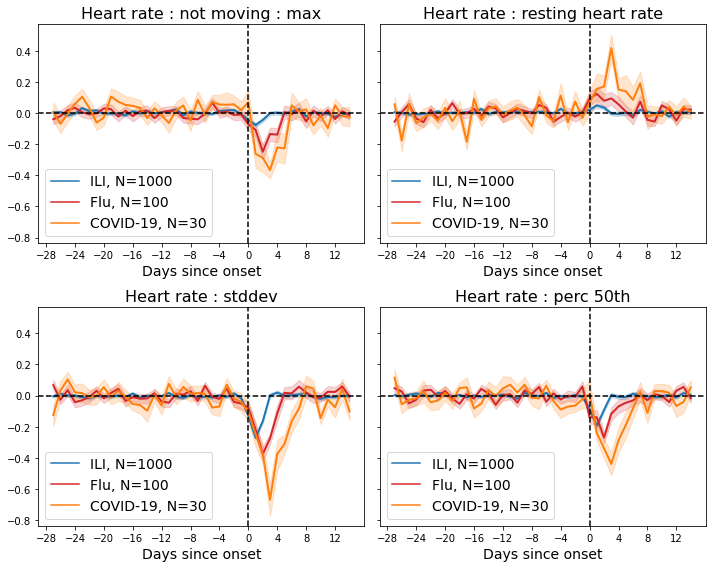

In [7]:
use_palette = [dict_hue[q] for q in ['ILI', 'Flu', 'Covid']]
use_hue_order = ['ILI, N=1000', 'Flu, N=100', 'COVID-19, N=30']
print(use_hue_order)

plot_cols = list(df_activity.loc[:,idx['0days_ago',:]].columns)
print([q[1] for q in plot_cols])

plot_trend_lines(df_activity[df_activity['labels', 'split']=='test'], plot_cols, use_palette, use_hue_order)

### Generate training dataset

* Only train on Covid cases (ILI_type==3) for a Healthy vs. COVID classifier (HvC)
* Only use 0 and 1 labeled days, skip buffer days for training

In [8]:
label_col = ('labels', 'training_labels')
split_col = ('labels', 'split')
type_col = ('labels', 'ILI_type')

days_ago = ['0days_ago', '1days_ago', '2days_ago', '3days_ago', '4days_ago']
feature_cols = ['heart_rate__not_moving__max', 
                'heart_rate__resting_heart_rate',
                'heart_rate__stddev',
                'heart_rate__perc_50th']

keep_train = (df_activity[label_col].isin([0,1]) 
                & (df_activity[split_col] == 'train')
                & (df_activity[type_col] == 3)
               )

X_train, y_train, filter_train = get_dataset(df_activity, keep_train, days_ago, feature_cols, label_col)

(3150, 20) (3150,)
Missing rows percent = 14.60%
  (labels, training_labels)  count  percent
0                         0   2100  66.6700
1                         1   1050  33.3300
2                     Total   3150 100.0000


In [9]:
keep_val = (df_activity[label_col].isin([0,1]) 
            & (df_activity[split_col] == 'val')
            & (df_activity[type_col] == 3)
             )

X_val, y_val, filter_val = get_dataset(df_activity, keep_val, days_ago, feature_cols, label_col)

(630, 20) (630,)
Missing rows percent = 14.44%
  (labels, training_labels)  count  percent
0                         0    420  66.6700
1                         1    210  33.3300
2                     Total    630 100.0000


### Train classifier with default hyperparameters -- to check

In [10]:
classifier_HvC, _, yh_val = run_xgb_class2(XGBClassifier(), X_train, y_train, X_val, y_val)

Train ROC: 0.9751
Val ROC: 0.8340


Check effect of missingness on performance -- at the highest missingness we see a drop on AUROC

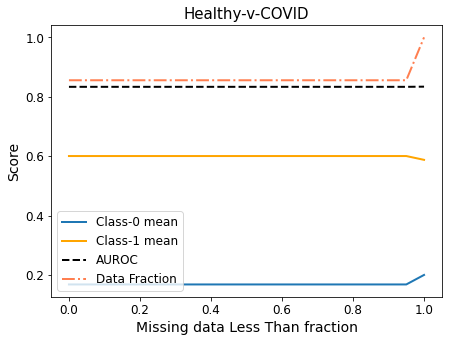

In [11]:
single_plot_missing_performance(y_val, yh_val, X_val, 'Healthy-v-COVID')

### Hyperparameter tune XGBoost

In [12]:
space = []
for i in range(100):
    space.append({
               #'objective' : 'multi:softmax',
               'n_estimators' : np.random.choice(np.arange(10, 200, 10), 1)[0],
               #'eta' : np.random.choice(np.arange(0.01, 0.1, 0.02), 1)[0],
               'max_depth' : np.random.choice(np.arange(1, 10), 1)[0],
               #'min_child_weight' : np.random.choice(np.arange(1, 6, 1), 1)[0],
               'subsample' : np.random.choice(np.arange(0.5, 1, 0.05), 1)[0],
               'gamma' : np.random.choice(np.arange(0.5, 1, 0.05), 1)[0],
               'colsample_bytree' : np.random.choice(np.arange(0.5, 1, 0.05), 1)[0],
               #'silent' : 1,
               #'tree_method' : 'gpu_hist',
               'scale_pos_weight' : np.random.choice(np.arange(1, 10, 1), 1)[0], #add positive class weight up-scaling
               'seed' : np.random.choice(np.arange(1,10000),1)[0]
               })

In [13]:
hypopt_HvC = run_xgb_hyperopt_2class(space, X_train[filter_train], y_train[filter_train],
                                     X_val[filter_val], y_val[filter_val])
hypopt_HvC.head(10)

,train_roc,val_roc,time_mins,n_estimators,max_depth,subsample,gamma,colsample_bytree,scale_pos_weight,seed
46,0.8748,0.8680,0.0004,20.0000,3.0000,0.8500,0.5500,0.9500,7.0000,4461.0000
67,0.9350,0.8669,0.0008,40.0000,4.0000,0.9500,0.8500,0.5500,1.0000,4376.0000
92,0.9053,0.8638,0.0010,90.0000,2.0000,0.9500,0.7500,0.5000,4.0000,8535.0000
84,0.8698,0.8625,0.0018,170.0000,1.0000,0.8500,0.7000,0.9500,5.0000,2495.0000
76,0.8598,0.8622,0.0008,90.0000,1.0000,0.7500,0.6500,0.9000,8.0000,680.0000
33,0.8686,0.8600,0.0011,170.0000,1.0000,0.8500,0.9500,0.8500,3.0000,6189.0000
12,0.8782,0.8598,0.0005,50.0000,2.0000,0.9500,0.5500,0.9000,5.0000,2962.0000
49,0.8605,0.8588,0.0010,90.0000,1.0000,0.8500,0.9000,0.9500,8.0000,560.0000
69,0.9631,0.8578,0.0013,40.0000,5.0000,0.9500,0.8000,0.9000,4.0000,1480.0000
23,0.8865,0.8559,0.0005,60.0000,2.0000,0.8000,0.5000,0.8000,3.0000,3124.0000


### Pick the best hyperparameters and rerun classifier

In [14]:
params = space[46]
classifier_HvC, _, yh_val = run_xgb_class2(XGBClassifier(**params), 
                                          X_train[filter_train], y_train[filter_train], 
                                          X_val[filter_val], y_val[filter_val])

Train ROC: 0.8748
Val ROC: 0.8680


#### Select thresholds for making predictions based on specificity cut-offs

In [15]:
yh_val = classifier_HvC.predict_proba(X_val)
ROC_HvC_val, spec_thresh_HvC_val = get_specificity_threshold(y_val[filter_val],
                                                         yh_val[filter_val,1],
                                                         [0.95, 0.9]
                                                        )

95% Specifivity cutoff = 0.8778
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       385
           1       0.83      0.57      0.68       154

    accuracy                           0.84       539
   macro avg       0.84      0.76      0.79       539
weighted avg       0.84      0.84      0.83       539

--------------------------------------------------
90% Specifivity cutoff = 0.8173
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       385
           1       0.72      0.64      0.68       154

    accuracy                           0.83       539
   macro avg       0.79      0.77      0.78       539
weighted avg       0.82      0.83      0.82       539

--------------------------------------------------


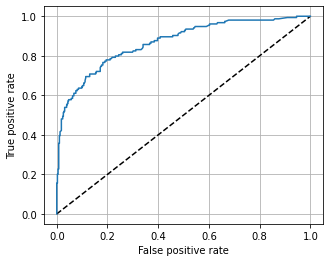

In [16]:
plot_roc(ROC_HvC_val[0], ROC_HvC_val[1])

### Evaluate on Test set -- keep all days in predictions

In [17]:
keep_test = (df_activity[split_col] == 'test')

X_test, y_test, filter_test = get_dataset(df_activity, keep_test, days_ago, feature_cols, label_col)

(48590, 20) (48590,)
Missing rows percent = 13.27%
  (labels, training_labels)  count  percent
0                        -1  24860  51.1600
1                         0  15820  32.5600
2                         1   7910  16.2800
3                     Total  48590 100.0000


Evaluate performance for selected specificity threshold

In [19]:
specificity_threshold = 0.95
pred_HvC, plot_df_HvC = run_get_predictions(classifier_HvC, X_test, y_test, filter_test,
                                             df_activity.loc[:,idx['labels',:]], 
                                             specificity_threshold, 
                                             spec_thresh_HvC_val[specificity_threshold],
                                            ['H', 'C'], ['id_participant_external'], 
                                            'days_since_onset')
print(pred_HvC.shape)

N = 1130
Cumulative recall shape= (129, 5)
Predictions shape= (48590, 11)
(48590, 11)


#### Look at cumulative recall at day 0, 3 and 6

In [20]:
plot_df_HvC[plot_df_HvC.days_since_onset.isin([0,3,6])]

,days_since_onset,ILI_type,cumsum_spec95_HvC,count_spec95_HvC,recall_fraction,Type
28,0,1.0000,317.0000,1000.0000,0.3170,"any ILI, N=1000"
31,3,1.0000,692.0000,1000.0000,0.6920,"any ILI, N=1000"
34,6,1.0000,796.0000,1000.0000,0.7960,"any ILI, N=1000"
71,0,2.0000,38.0000,100.0000,0.3800,"Flu, N=100"
74,3,2.0000,84.0000,100.0000,0.8400,"Flu, N=100"
77,6,2.0000,94.0000,100.0000,0.9400,"Flu, N=100"
114,0,3.0000,8.0000,30.0000,0.2667,"COVID, N=30"
117,3,3.0000,28.0000,30.0000,0.9333,"COVID, N=30"
120,6,3.0000,29.0000,30.0000,0.9667,"COVID, N=30"


In [21]:
use_palette = [dict_hue[q] for q in ['ILI', 'Flu', 'Covid']]
use_hue_order = list(pred_HvC.Type.unique())
print(use_hue_order)

['any ILI, N=1000', 'Flu, N=100', 'COVID, N=30']


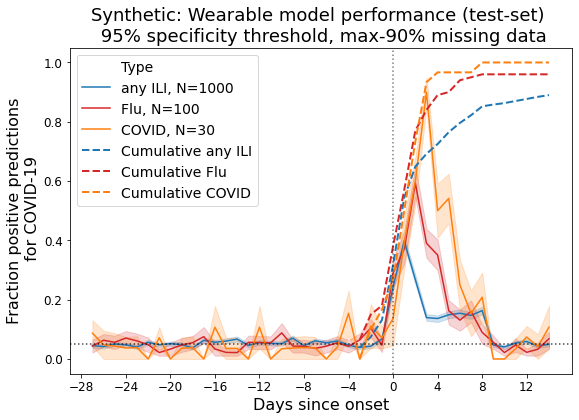

In [22]:
fig, ax = plot_spec_recall_since_onset(pred_HvC, plot_df_HvC, specificity_threshold,
                                       'pred_spec95_HvC', 
                                        use_palette, use_hue_order,
                                        'Wearable model performance (test-set)',
                                        0.9, 'cumsum_spec95_HvC', 'count_spec95_HvC',
                                       'COVID-19', 'Synthetic', 'Type', 'days_since_onset')
fig

### Feature importance

In [23]:
get_feature_importance(classifier_HvC)

,feature_name,gain
0,1days_ago heart_rate__perc_50th,114.5559
1,0days_ago heart_rate__stddev,51.2001
2,0days_ago heart_rate__not_moving__max,31.0160
3,0days_ago heart_rate__perc_50th,27.0092
4,0days_ago heart_rate__resting_heart_rate,24.4656


In [ ]:
### SAVE XGBOOST AS JSON
#classifier_HvC.save_model('model.json')